In [6]:
import os
from pathlib import Path
import requests
from tqdm import tqdm
from typing import Union, List

import math
import torch
import numpy as np
import audiotools
import dasp_pytorch
import auraloss
# import laion_clap
from audiotools import AudioSignal

from transformers import BertForMaskedLM


import matplotlib.pyplot as plt
%matplotlib inline

NOTEBOOKS_DIR = Path(os.path.abspath(''))
PROJECT_DIR = NOTEBOOKS_DIR.parent
ASSETS_DIR = PROJECT_DIR / "assets"
PRETRAINED_DIR = PROJECT_DIR / "pretrained"
DATA_DIR = PROJECT_DIR / "data"
RUNS_DIR = PROJECT_DIR / "runs"
EXPERIMENTS_DIR = PROJECT_DIR / "experiments"
EXP_AUDEALIZE_DIR = EXPERIMENTS_DIR / "audealize_comp"

### Top Words for EQ
- warm	64
- cold	34
- soft	29
- loud	26
- happy	22
- bright	19
- soothing	17
- harsh	16
- heavy	15
- cool	14

top10_eq = ["warm", "cold", "soft", "loud", "happy", "bright", "soothing", "harsh", "heavy", "cool"]


### Input Signal

In [7]:
def load_examples(dir_path):
    exts = ["mp3", "wav", "flac"]
    example_files = [list(dir_path.rglob(f"*.{e}")) for e in exts]
    example_files = sum(example_files, [])  # Trick to flatten list of lists
    return example_files

def find_paths_with_keyword(file_paths, keywords, returnSingle=False):
    """
    Find paths containing all given keywords.
    
    Args:
    - file_paths (list of str or PosixPath): List of file paths to search.
    - keywords (list of str): List of keywords to search for.
    - return_single (bool): If True, return only the first match. If False, return a list of all matches.
    
    Returns:
    - str or list of str: Single path or list of paths matching the keywords.
    """
    if returnSingle:
        return next((file for file in file_paths if all(keyword in str(file) for keyword in keywords)), None)
    else:
        return [file for file in file_paths if all(keyword in str(file) for keyword in keywords)]

def load_and_find_path_with_keyword(dir_path, keywords, returnSingle=False):
    """
    Search for files given a folder (can be nested) and multiple keywords.
    
    Args:
    - dir_path (str or PosixPath): Parent directory to pull all audio files from.
    - keywords (list of str): List of keywords to search for.
    - return_single (bool): If True, return only the first match. If False, return a list of all matches.
    
    Returns:
    - str or list of str: Single path or list of paths matching the keywords.
    """
    examples_all = load_examples(dir_path)
    return find_paths_with_keyword(examples_all, keywords, returnSingle=returnSingle)


In [3]:
# input files
input_raw_piano = load_and_find_path_with_keyword(ASSETS_DIR, ["piano"], returnSingle=True)
input_raw_drums = load_and_find_path_with_keyword(ASSETS_DIR, ["drums"], returnSingle=True)
input_raw_speech = load_and_find_path_with_keyword(ASSETS_DIR, ["225"], returnSingle=True)

print(input_raw_piano)
# input_signal = AudioSignal(input_raw_voice)
# input_signal.widget()

#same as below
# all_examples = load_examples(ASSETS_DIR)
# search_term = "guitar"
# path = find_path_with_keyword(all_examples, search_term)
# print(path)


/home/annie/research/text2fx/assets/audealize_examples/piano.wav


### Ground Truth: Audealize Outputs

In [ ]:
# to do
# Loading output files from MS CLAP experiment


### vs MS CLAP Outputs

#### Loading All Output Files

In [9]:
# Loading output files from MS CLAP experiment

# Returning all MS CLAP output final .wav files
EXP_AUDEALIZE_DIR = EXPERIMENTS_DIR / "audealize_comp" 
msclap_out_ALL = load_and_find_path_with_keyword(EXP_AUDEALIZE_DIR, ["final"])
for path in msclap_out_ALL:
    print(path)
# # Example 1: searching by target_text warm and warm
msclap_out_WARM = load_and_find_path_with_keyword(EXP_AUDEALIZE_DIR, ["final", "warm"])
for path in msclap_out_WARM:
    print(path)
    
# # EXAMPLE 2
msclap_out_speech_warm = load_and_find_path_with_keyword(EXP_AUDEALIZE_DIR, ["warm", "speech"])
for path in msclap_out_speech_warm:
    print(path)

/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_happy/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_bright/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_cool/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_loud/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_warm/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_cold/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_soft/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_soothing/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_heavy/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/guitar/this_sound_is_harsh/final.wav
/home/annie/research/text2fx/experiments/audealize_comp/speech/comparat

#### Loading Just Speech Ones

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_happy/final.wav
Target: this sound is warm



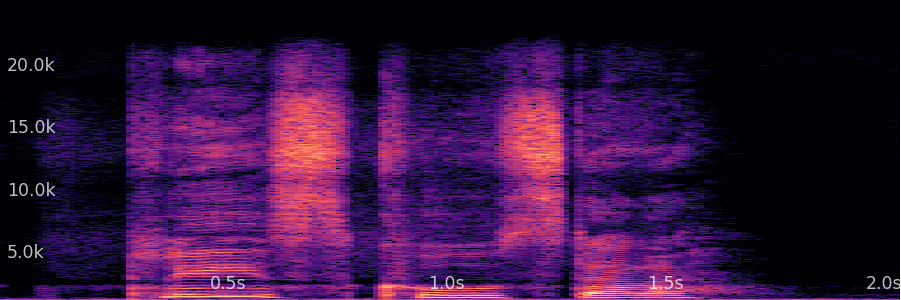
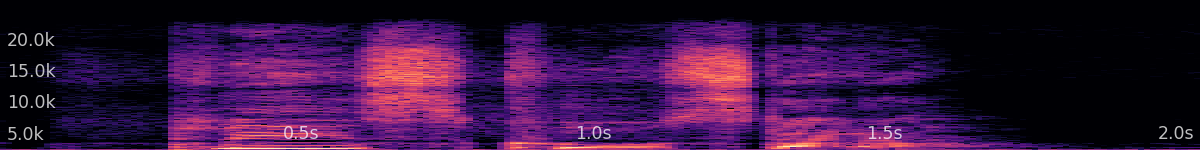

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_happy/final.wav
Target: this sound is cold



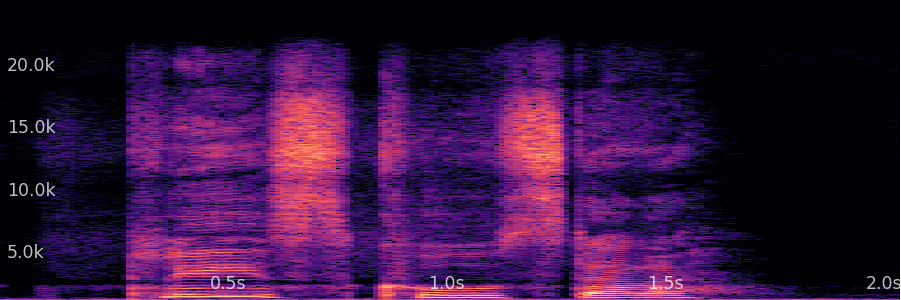
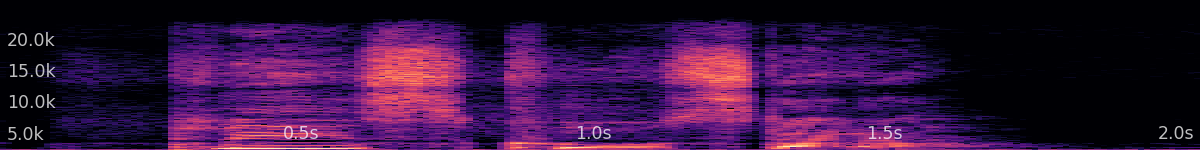

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_happy/final.wav
Target: this sound is soft



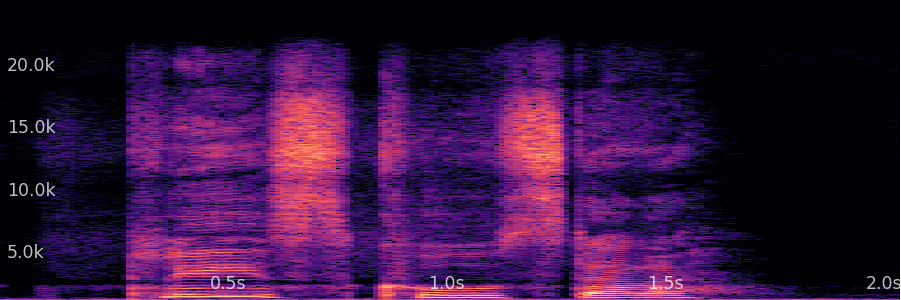
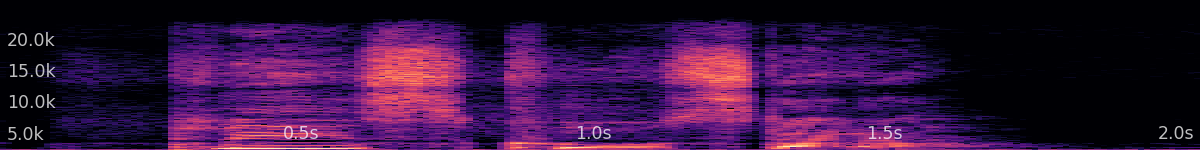

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_happy/final.wav
Target: this sound is loud



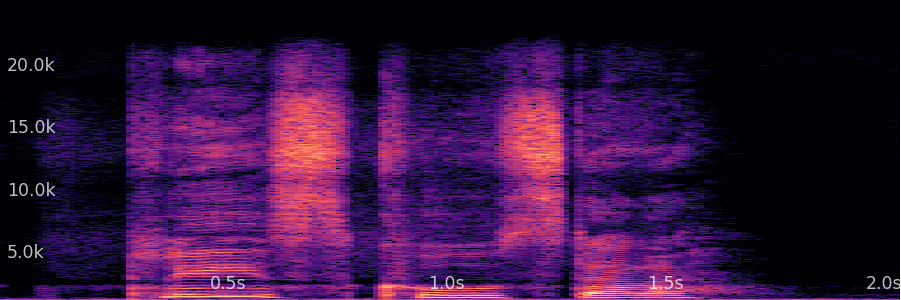
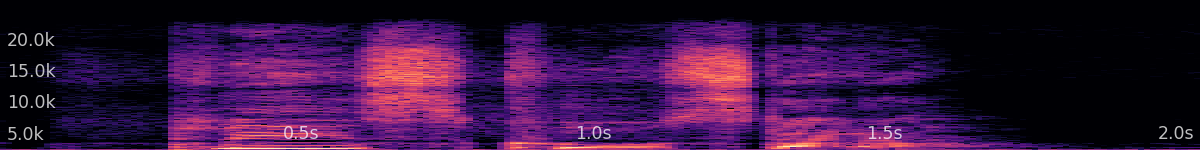

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_happy/final.wav
Target: this sound is happy



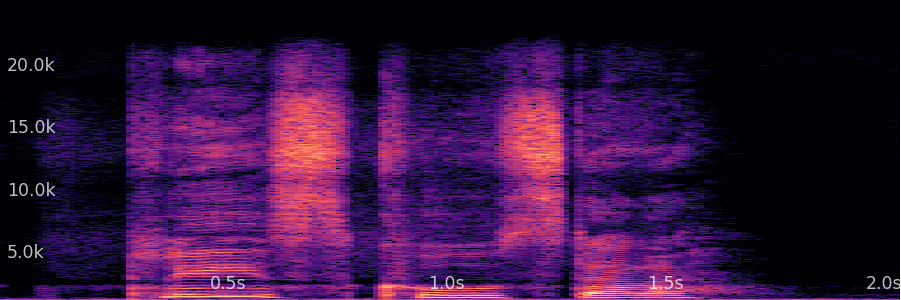
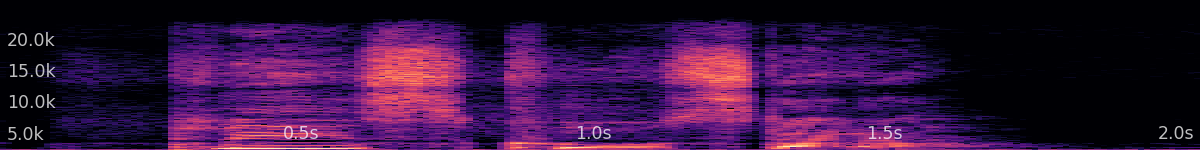

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_bright/final.wav
Target: this sound is bright



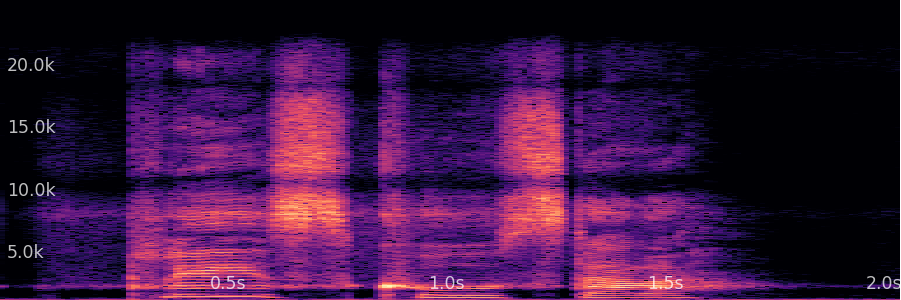
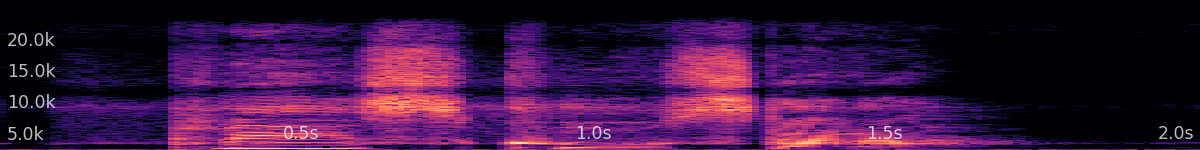

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_bright/final.wav
Target: this sound is soothing



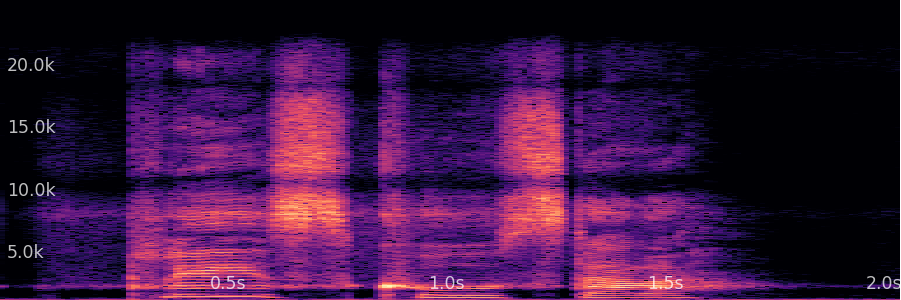
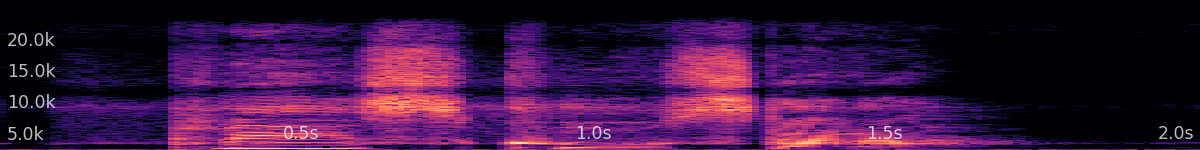

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_happy/final.wav
Target: this sound is harsh



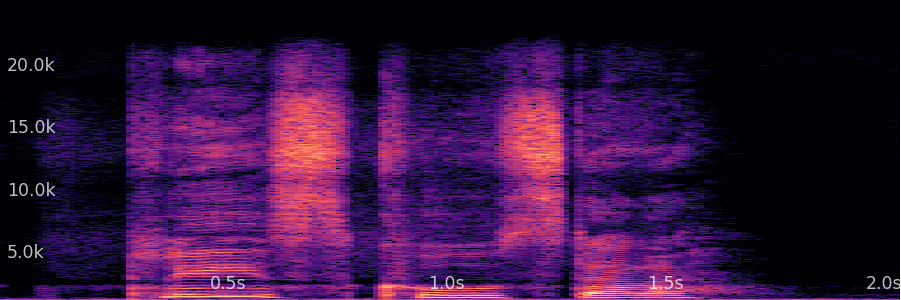
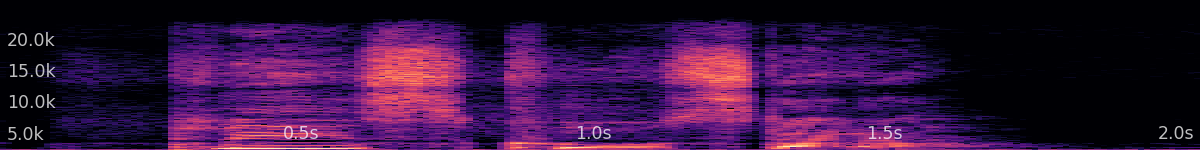

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_happy/final.wav
Target: this sound is heavy



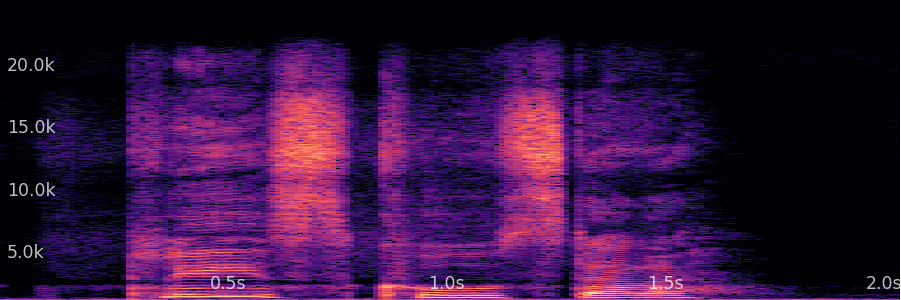
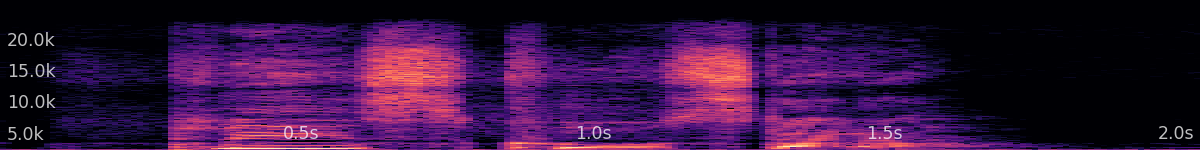

/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_happy/final.wav
Target: this sound is cool



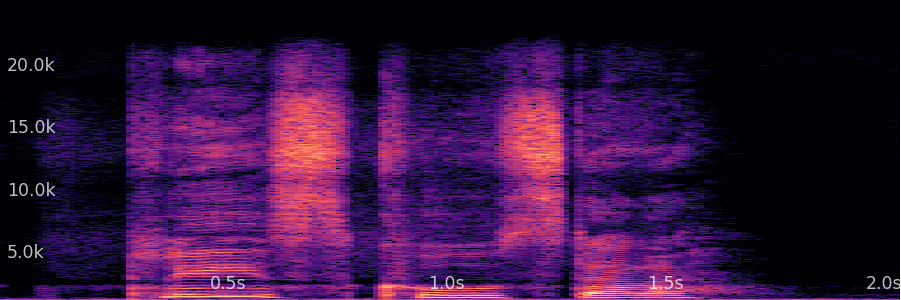
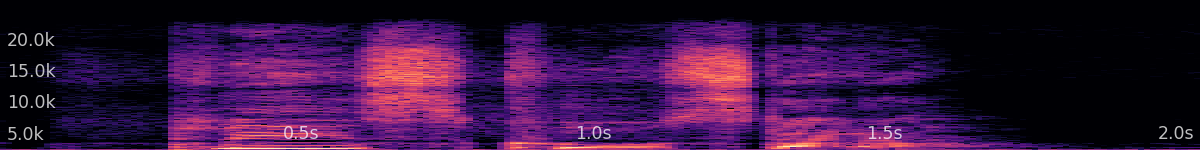

In [11]:
#Comparing all SPEECH ONES
msclap_out_ALL_SPEECH = load_and_find_path_with_keyword(EXP_AUDEALIZE_DIR, ["normal", "speech", "final"])
prefix = "this sound is "
top10_eq = ["warm", "cold", "soft", "loud", "happy", "bright", "soothing", "harsh", "heavy", "cool"]
for word in top10_eq:
    path_word = find_paths_with_keyword(msclap_out_ALL_SPEECH, word, returnSingle=True)
    print(path_word)
    outsig_word = AudioSignal(path_word)
    print(f'Target: {prefix}{word}')
    outsig_word.widget()

#### Setting Up Audio-Audio Loss Metrics

In [68]:
mrstft = auraloss.freq.MultiResolutionSTFTLoss()

def compare_loss_byword(word, baseline_paths, output_paths, loss_funct=mrstft):
    #word -> e.g. 'warm'
    #baseline_paths: list of paths (str or PosixPath type) of basline where audealize output files
    # output_folder: list of paths (str or PosixPath type) of where ms output paths are e.g. msclap_out_files
    path_out = find_path_with_keyword(output_paths, word) #output, msclap_out_files
    path_baseline = find_path_with_keyword(baseline_paths, word) #baseline, wherever the audealize
    
    outSig = AudioSignal(path_out)
    baselineSig = AudioSignal(path_baseline)

    outSig_samples = outSig.to_mono().samples
    baselineSig_samples = baselineSig.to_mono().samples
    loss = loss_funt(outSig_samples, baselineSig_samples)

    return loss

def compare_loss_anyfiles(file_baseline, file_compare, loss_funct=mrstft):
    baselineSig = AudioSignal(file_baseline)
    outSig = AudioSignal(file_compare)

    baselineSig_samples = baselineSig.to_mono().samples
    outSig_samples = outSig.to_mono().samples

    loss = loss_funct(baselineSig_samples, outSig_samples)
    
    return loss

#### Comparing Loss for Speech Files

In [78]:
# testing for single file warm
SPEECH_DIR_OUTS = EXP_AUDEALIZE_DIR / "speech"
file_baseline = input_raw_speech #replace with audealize_speech_baseline_warm
file_compare = load_and_find_path_with_keyword(SPEECH_DIR_OUTS, ["normal", "final", "warm"])[0]
# file_compare = find_path_with_keyword(msclap_out_files, 'bright', returnSingle=True)

print(file_baseline)
print(file_compare)
compare_loss_anyfiles(file_baseline, file_compare, loss_funct=mrstft)

/home/annie/research/text2fx/assets/speech_examples/VCTK_p225_001_mic1.flac
/home/annie/research/text2fx/experiments/audealize_comp/speech/normal/this_sound_is_warm/final.wav


tensor(1.3190)

In [85]:
file_baseline = input_raw_speech #file to compare
# testing for multiple Files
for word in top10_eq:
    # print(file_compare)
    file_compare = load_and_find_path_with_keyword(SPEECH_DIR_OUTS, ["final", "normal", word])[0]
    loss = compare_loss_anyfiles(file_baseline, file_compare, loss_funct=mrstft)
    relative_path = Path(file_compare).relative_to(SPEECH_DIR_OUTS)
    # print(relative_path, word, loss)
    print(word, loss)

warm tensor(1.3190)
cold tensor(1.3791)
soft tensor(2.0303)
loud tensor(2.3759)
happy tensor(1.4485)
bright tensor(2.0928)
soothing tensor(1.6308)
harsh tensor(2.3080)
heavy tensor(2.1481)
cool tensor(1.6656)


In [86]:
file_baseline = input_raw_speech #file to compare audealize
# testing for multiple Files
top10_eq_comp = ["warmer", "colder", "softer", "louder", "happier", "brighter", "more_soothing", "harsher", "heavier", "cooler"]
for word in top10_eq_comp:
    # print(file_compare)
    file_compare = load_and_find_path_with_keyword(SPEECH_DIR_OUTS, ["final", "comparatives", word])[0]
    loss = compare_loss_anyfiles(file_baseline, file_compare, loss_funct=mrstft)
    relative_path = Path(file_compare).relative_to(SPEECH_DIR_OUTS)
    # print(relative_path, word, loss)
    print(word, loss)

warmer tensor(1.6625)
colder tensor(1.2586)
softer tensor(2.3829)
louder tensor(2.7241)
happier tensor(1.2027)
brighter tensor(1.7968)
more_soothing tensor(1.6633)
harsher tensor(2.2778)
heavier tensor(2.1969)
cooler tensor(1.7824)
